In [5]:
import sys
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import cm
from scipy.signal import detrend

# Custom package
sys.path.append('/home/rrp000/sea_ice/code/')
from icepack import get_dataset
from icepack.analysis import *
from icepack.splot import *
from icepack.skill import *

# Some useful lists and dicts
monthletters = ['J','F','M','A','M','J','J','A','S','O','N','D']
monthstr = ['01','02','03','04','05','06','07','08','09','10','11','12']
monthdict = {1:r'$\mathbf{January}$',
             2:r'$\mathbf{February}$',
             3:r'$\mathbf{March}$',
             4:r'$\mathbf{April}$',
             5:r'$\mathbf{May}$',
             6:r'$\mathbf{June}$',
             7:r'$\mathbf{July}$',
             8:r'$\mathbf{August}$',
             9:r'$\mathbf{September}$',
             10:r'$\mathbf{October}$',
             11:r'$\mathbf{November}$',
             12:r'$\mathbf{December}$'}

method = 'mean'
daterange = (1990,2015)
daterange_clim = (1990,2015)

mask = xr.open_dataset("~/sea_ice/data/masks/land_all.nc")

In [6]:
# open data
sic = get_dataset('Had2CIS')

# calculate SIE and anomalies
sie_Had2CIS = get_iceextent(sic, mask, lat_bounds=(-90,0), ensemble=None)
sie_anom_Had2CIS = get_anomalies(sie_Had2CIS,'SIE',ref_period=daterange)

In [7]:
# open data
sic = get_dataset('OSI-SAF')

# calculate SIE and anomalies
sie_OSISAF = get_iceextent(sic, mask, lat_bounds=(-90,0), ensemble=None)
sie_anom_OSISAF = get_anomalies(sie_OSISAF,'SIE',ref_period=daterange)

In [3]:
# CELL TAKES ~1 MINUTE TO RUN

# open data and format time
sic_CanESM5_init = get_dataset('CanESM5.0_i')
sic_CanESM5_init = [format_time_coord(data,f'1981-{monthstr[i]}',f'202{int(np.heaviside(i,0))}-{monthstr[i-1]}',freq='M') for i,data in enumerate(sic_CanESM5_init)]

# calculate SIE (ensemble mean) and SIE anomalies
print("Calculating SIE")
sie_CanESM5_init = []
for i,sic in enumerate(sic_CanESM5_init):
    sie_CanESM5_init.append(get_iceextent(sic, mask, lat_bounds=(-90,0), multiply_input_by=1e-2, ensemble='mean'))

# add a lead time coordinate to the SIE data set
print("Adding a lead time coordinate")
for i in range(len(sie_CanESM5_init)):
    im = i + 1
    sie_CanESM5_init[i]['lead'] = (sie_CanESM5_init[i]['time.month'] - im)%12

# re-sort by leadtime
sie_CanESM5_init_lt = [xr.merge([sie_CanESM5_init[im-1].where(sie_CanESM5_init[im-1]['lead']==lead,drop=True) for im in np.arange(1,13)]) for lead in range(12)]

Calculating SIE
Adding a lead time coordinate


In [4]:
skill_CanESM5, sig_CanESM5 = get_skillmatrix(sie_Had2CIS,sie_CanESM5_init_lt,daterange=(1985,2015),significance_test=True)

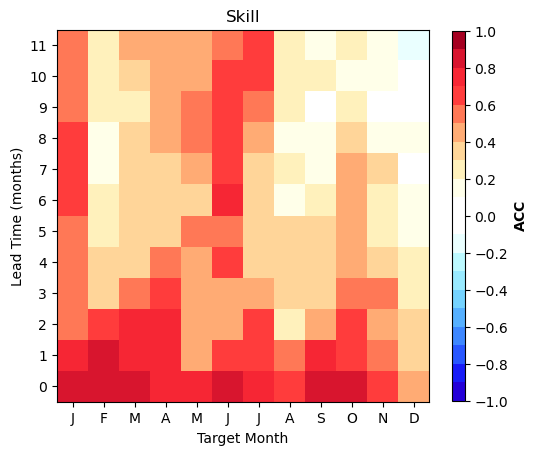

In [5]:
from icepack.splot import plot_skillmatrix

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(6,6))
skill_plot = plot_skillmatrix(ax=ax, skill_matrix=skill_CanESM5, cmap_path='../cmaps/cmap_jet3.mat')
ax.set_xlabel("Target Month")

# colour bar
skill_plot.set_clim([-1.,1.])
cticks = np.linspace(-1.,1.,11)
cbar = plt.colorbar(skill_plot,ax=ax,aspect=30,shrink=.8,ticks=cticks,location='right',pad=0.05,label=r"$\mathbf{ACC}$")

plt.show()

In [8]:
import glob

# Import data into a list
paths = sorted(glob.glob("/home/rrp000/sea_ice/data/model/CanESM5/v0/init/sic/1x1/*.nc"))
modeldata_sic = [xr.open_dataset(path) for path in paths]
modeldata_sie = [get_iceextent(modeldata,
                               mask,
                               lat_bounds=(-90,0),
                               ensemble='mean',
                               multiply_input_by=1e-2) for modeldata in modeldata_sic]
modeldata_sie_bylead = [xr.merge([modeldata_sie[im-1].where((modeldata_sie[im-1]['time.month']-im)%12==lead,drop=True) for im in np.arange(1,13)]) for lead in range(12)]
skill_model, sig_model = get_skillmatrix(sie_Had2CIS,
                                modeldata_sie_bylead,
                                daterange=(1990,2014),
                                significance_test=True)
skill_model2, sig_model2 = get_skillmatrix(sie_OSISAF,
                                modeldata_sie_bylead,
                                daterange=(1990,2014),
                                significance_test=True)

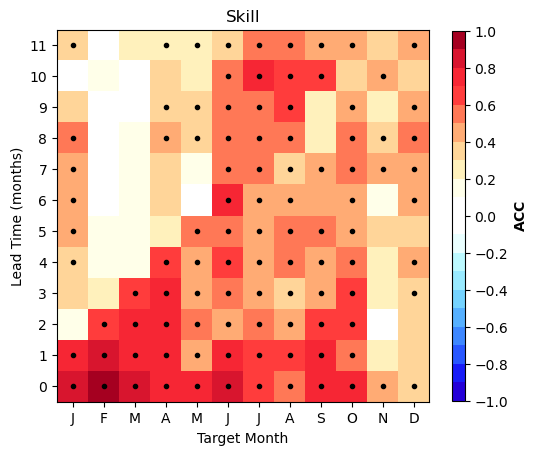

In [9]:
from icepack.splot import plot_skillmatrix

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(6,6))
skill_plot = plot_skillmatrix(ax=ax, skill_matrix=skill_model, sig_matrix=sig_model, cmap_path='../cmaps/cmap_jet3.mat')
ax.set_xlabel("Target Month")

# colour bar
skill_plot.set_clim([-1.,1.])
cticks = np.linspace(-1.,1.,11)
cbar = plt.colorbar(skill_plot,ax=ax,aspect=30,shrink=.8,ticks=cticks,location='right',pad=0.05,label=r"$\mathbf{ACC}$")

plt.show()

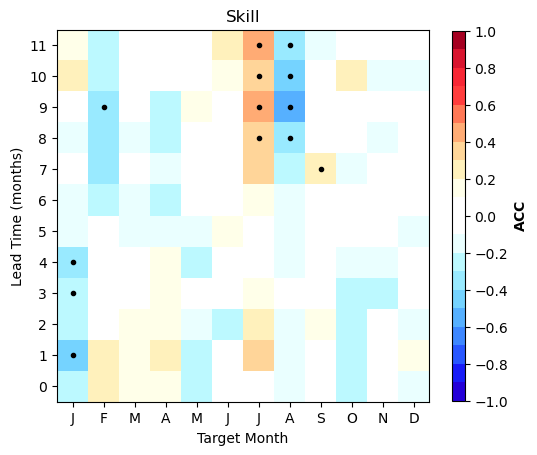

In [10]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(6,6))
skill_plot = plot_skillmatrix(ax=ax, skill_matrix=skill_model2, sig_matrix=sig_model2, cmap_path='../cmaps/cmap_jet3.mat')
ax.set_xlabel("Target Month")

# colour bar
skill_plot.set_clim([-1.,1.])
cticks = np.linspace(-1.,1.,11)
cbar = plt.colorbar(skill_plot,ax=ax,aspect=30,shrink=.8,ticks=cticks,location='right',pad=0.05,label=r"$\mathbf{ACC}$")

plt.show()